# <p style="text-align: center;">Previsión de Fallas</p>

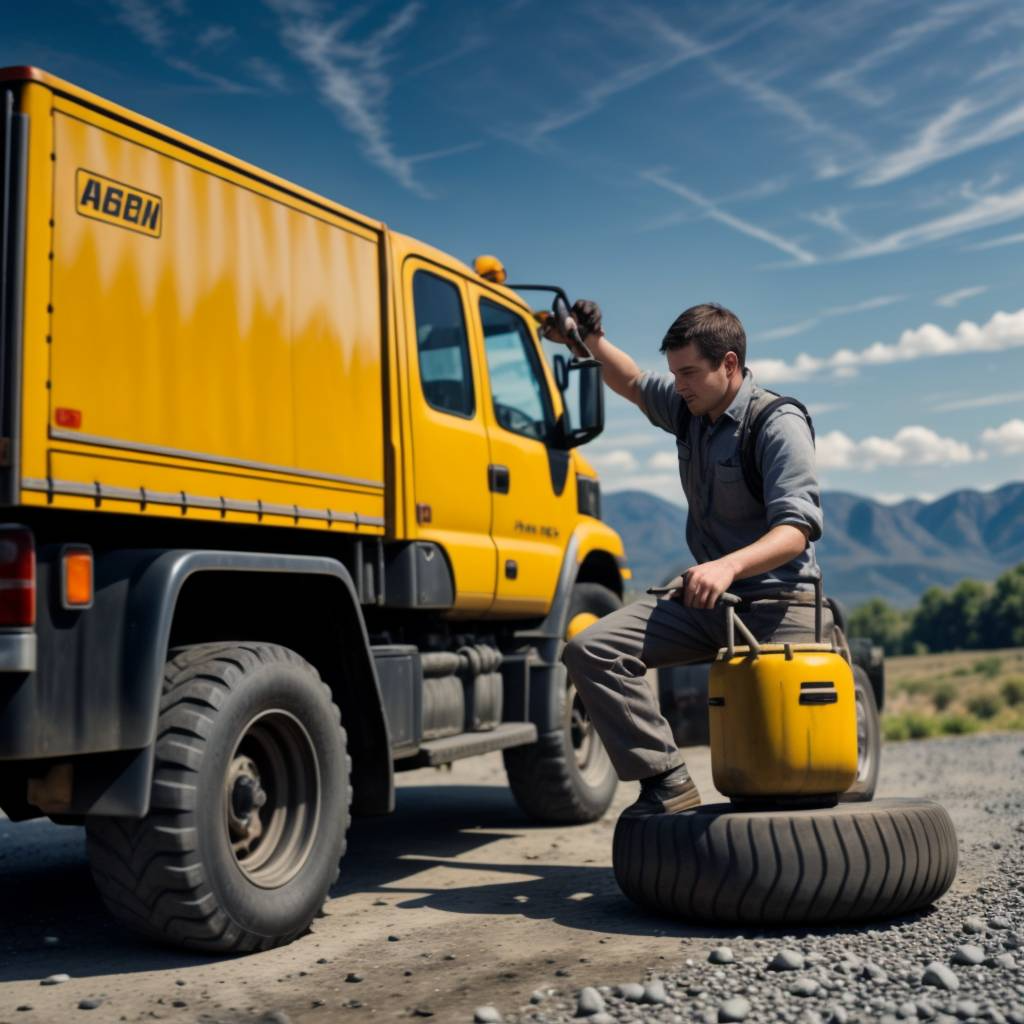 Imagen creada en Krea.ai

### Funcionalidad

En una red de transporte logístico es de vital importancia que todos sus actores funcionen de manera sincronizada, garantizando que se cumplan con los tiempos de entrega establecidos para los pedidos de manera oportuna. Si bien ocurre de manera poco frecuente, una falla en algún dispositivo podría desencadenar una serie de incumplimientos y costos que podrían acarrear con el incumplimiento de indicadores importantes para el negocio. Todo esto pudiendo evitarse con un mantenimiento oportuno o generando una alerta temprana que permita tomar acciones preventivas en lugar de reactivas. 

Evitar estas fallas de forma oportuna, genera ahorros en términos de dinero y también evita riesgos en la seguridad de las personas en contacto con los dispositivos. Es por esto, que a lo largo de este Notebook utilizaremos la información agregada de varaibles de telemetría suministrada para la flota de dispositivos entre **enero y noviembre de 2015**, para construir un modelo que trate de predecir de la manera más precisa posible la cantidad de fallas.

Trabajaremos en técnicas para el balanceo de los conjuntos debido a la poca cantidad de fallas en los registros y posteriormente evaluaremos un par de modelos con base a una función de costo que penaliza el no detectar una falla pero también el realizar un mantenimiento de manera innecesaria, considerando como falla algo que no lo era.

In [1]:
#!pip install itables
#!pip install -U scikit-learn
#!pip install -U imbalanced-learn
#!pip install xgboost


In [2]:
from itables import init_notebook_mode
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [3]:
full_devices = pd.read_csv ("C:/Users/Garzonm1/Desktop/Teste Te╠ücnico - DS/full_devices.csv", encoding='latin1',engine='python')

In [4]:
full_devices

date    device  failure  attribute1  attribute2  attribute3  \
0       2015-01-01  S1F01085        0   215630672          56           0   
1       2015-01-01  S1F0166B        0    61370680           0           3   
2       2015-01-01  S1F01E6Y        0   173295968           0           0   
3       2015-01-01  S1F01JE0        0    79694024           0           0   
4       2015-01-01  S1F01R2B        0   135970480           0           0   
...            ...       ...      ...         ...         ...         ...   
124489  2015-11-02  Z1F0MA1S        0    18310224           0           0   
124490  2015-11-02  Z1F0Q8RT        0   172556680          96         107   
124491  2015-11-02  Z1F0QK05        0    19029120        4832           0   
124492  2015-11-02  Z1F0QL3N        0   226953408           0           0   
124493  2015-11-02  Z1F0QLC1        0    17572840           0           0   

        attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0               52           6      407438           0           0           7  
1                0           6      403174           0           0           0  
2                0          12      237394           0           0           0  
3                0           6      410186           0           0           0  
4                0          15      313173           0           0           3  
...            ...         ...         ...         ...         ...         ...  
124489           0          10      353705           8           8           0  
124490           4          11      332792           0           0          13  
124491           0          11      350410           0           0           0  
124492           0          12      358980           0           0           0  
124493           0          10      351431           0           0           0  

[124494 rows x 12 columns]

## Entendimiento y preparación de los datos

In [5]:
# Convertir la fecha al tipo de datos correspondiente
full_devices["date"] = pd.to_datetime(full_devices["date"], format='%Y-%m-%d')

In [6]:
full_devices.describe()

date        failure    attribute1  \
count                         124494  124494.000000  1.244940e+05   
mean   2015-04-16 05:20:49.737337088       0.000851  1.223881e+08   
min              2015-01-01 00:00:00       0.000000  0.000000e+00   
25%              2015-02-09 00:00:00       0.000000  6.128476e+07   
50%              2015-03-27 00:00:00       0.000000  1.227974e+08   
75%              2015-06-17 00:00:00       0.000000  1.833096e+08   
max              2015-11-02 00:00:00       1.000000  2.441405e+08   
std                              NaN       0.029167  7.045933e+07   

          attribute2     attribute3     attribute4     attribute5  \
count  124494.000000  124494.000000  124494.000000  124494.000000   
mean      159.484762       9.940455       1.741120      14.222669   
min         0.000000       0.000000       0.000000       1.000000   
25%         0.000000       0.000000       0.000000       8.000000   
50%         0.000000       0.000000       0.000000      10.000000   
75%         0.000000       0.000000       0.000000      12.000000   
max     64968.000000   24929.000000    1666.000000      98.000000   
std      2179.657730     185.747321      22.908507      15.943028   

          attribute6     attribute7     attribute8     attribute9  
count  124494.000000  124494.000000  124494.000000  124494.000000  
mean   260172.657726       0.292528       0.292528      12.451524  
min         8.000000       0.000000       0.000000       0.000000  
25%    221452.000000       0.000000       0.000000       0.000000  
50%    249799.500000       0.000000       0.000000       0.000000  
75%    310266.000000       0.000000       0.000000       0.000000  
max    689161.000000     832.000000     832.000000   18701.000000  
std     99151.078547       7.436924       7.436924     191.425623

- No hay valores nulos en ninguna de las columnas
- Periodo de tiempo: desde enero hasta 2 de noviembre del año 2015, 10 meses de información completa de la flota de vehículos
- Failure binaria, más del 75% de los dispositivos no han tenido fallas
- Attributes: 1 y 6 son aquellos con escala mucho mayor a los demás por tanto deben ser escalados entre sí todos los atributos. Además los atributos 2,3,4,7,8 y 9 tienen más del 75% de los valores concentrados en 0 mostrando fuerte asimetría positiva.

Sabiendo que se busca predecir la variable failure a partir de los atributos agregados de telemetría, vamos a analizar primero las dos variables de "Fecha" y "Device" para decidir si incluirlas al modelo predictivo.

In [7]:
# Calcular la cantidad de valores únicos de dispositivos

unique_count = full_devices['device'].nunique()

print(f"Cantidad de valores únicos en device: {unique_count}")


Cantidad de valores únicos en device: 1169


Agregar esta variable al modelo propuesto implicaría transformarla a 1168 variables dummies, y debido a que el enfoque del problema se trata de utilizar los atributos agergados de telemetría para predecir el fallo, no utilizaremos esta variable en el modelo a realizar.

Sin embargo a manera de propuesta, se podría separar esa categoría de dispositivos en una categoría mayor con el objetivo de no aumentar mucha dimensionalidad. En caso de no existir, un ejemplo puede ser separar del código **"S1F01E6Y"** el fragmento **"S1F01"**. Posteriormente, para estas categorías validar estadísticamente si existe o no una diferencia significativa en las medias cuando se presentan fallas en ese tipo de dispositivo.

Otra propuesta para manejar esta cantidad de dispositivos es utilizar un **LabelEncoder**, que permite transformar estas categorías en valores numéricos segun pesos asignados, sin aportar mayor grado de dimensionalidad como en el caso de variables dummy.



In [8]:
# Agrupar por fecha y 'failure', y contar las ocurrencias
conteos = full_devices.groupby(['date', 'failure']).size().reset_index(name='Conteo')

# Ordenar el DataFrame por la columna de fechas
conteos = conteos.sort_values(by='date')

# Crear el gráfico de líneas con puntos
fig = go.Figure()

# Agregar un trazo por cada categoría única de 'failure'
for failure_category in conteos['failure'].unique():
    df_filtered = conteos[conteos['failure'] == failure_category]
    fig.add_trace(go.Scatter(x=df_filtered['date'], y=df_filtered['Conteo'],
                             mode='markers+lines',
                             name=str(failure_category)))

# Establecer el diseño del gráfico
fig.update_layout(title='Línea de Tiempo vs Numero de registros por Categoría de Fallo',
                  xaxis_title='Fecha',
                  yaxis_title='Registros',
                  showlegend=True)

# Mostrar el gráfico
fig.show()


Esta gráfica nos permite rechazar una hipótesis que surgió al momento de observar las variables y es: ¿Está relacionada la fecha, o bien el tiempo de uso de ese dispositivo, con una posible falla?. Si lo anterior fuera cierto, encontraríamos más puntos rojos del lado derecho que del izquierdo en la gráfica. Por el contrario, haciendo zoom en la línea roja vemos que no tiene una concentración específica en algún periodo del año. Motivo por el cual desmentimos la asociación y dejamos esta variable fuera del modelo.

Ahora, analizaremos el desbalanceo visto entre las clases y será tratado para entrenar un modelo que pueda predecir correctamente las fallas en dispositivos.

In [9]:
import matplotlib.pyplot as plt
full_devices["failure"] = full_devices["failure"].astype('category')

# Contar la frecuencia de cada dispositivo
device_counts = full_devices["failure"].value_counts()
# Calcular los porcentajes
percentage = device_counts / device_counts.sum() * 100

# Crear una tabla con device_counts y percentage
summary_table = pd.DataFrame({
    'device_counts': device_counts,
    'percentage': percentage
})

# Formatear la columna "percentage" para agregar el símbolo "%"
summary_table['percentage'] = summary_table['percentage'].map('{:.2f}%'.format)

# Mostrar la tabla
summary_table

device_counts percentage
failure                          
0               124388     99.91%
1                  106      0.09%

Convertimos la variable "failure" a categórica ya que es una opción binaria para determinar si existe o no falla en ese dispositivo. De la tabla anterior podemos ver el desbalanceo existente entre estas dos categorías, lo cual tiene una influencia importante directa sobre el modelo. 

Como primera medida, dividimos desde ya el conjunto original en conjuntos de entrenamiento y prueba con el objetivo de no filtrar información luego de procesarla e incurrir en posibles "data leakage". Para que la partición anterior tenga suficientes elementos de failure = 1 manteniendo sus proporciones, tanto en entrenamiento como en prueba se implementa la técnica de estratificación para la variable y.

In [10]:
# Separación de las características (X) y la variable objetivo Failure(y)
prediccion = full_devices.drop(["date","device"],axis=1)

X = prediccion.drop('failure', axis=1)
y = prediccion['failure']

# División del conjunto de datos en entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1519)

# Verificación de las proporciones de las clases en los conjuntos de entrenamiento y prueba
train_proportion = y_train.value_counts(normalize=True)
test_proportion = y_test.value_counts(normalize=True)

print("Proporción de clases en el conjunto de entrenamiento:\n", train_proportion)
print("\nProporción de clases en el conjunto de prueba:\n", test_proportion)


Proporción de clases en el conjunto de entrenamiento:
 failure
0    0.999147
1    0.000853
Name: proportion, dtype: float64

Proporción de clases en el conjunto de prueba:
 failure
0    0.999157
1    0.000843
Name: proportion, dtype: float64


Una vez garantizado que tanto en el conjunto de entrenamiento como en prueba tengamos valores de failure=1, trabajamos sobre el conjunto en el que vamos a entrenar el modelo, iniciando por aplicar técnicas de sobremuestreo en la clase minoritaria y submuestreo en la mayoritaria. Esto con el objetivo de balancear un poco mejor ambas categorías y entrenar el modelo con esos datos.

In [11]:
# Configuración de la estrategia de sobremuestreo y submuestreo
over_strategy = 0.15  # Aumentar la clase minoritaria al 15%
under_strategy = 0.5  # Reducir la clase mayoritaria al 50%

# Creación del pipeline de sobremuestreo y submuestreo
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=over_strategy)),
    ('under', RandomUnderSampler(sampling_strategy=under_strategy))
])

# Aplicación a conjunto de entrenamiento
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Verificación de las nuevas proporciones de las clases después del remuestreo
resampled_train_proportion = pd.Series(y_train_resampled).value_counts(normalize=True)

# Proporciones en el conjunto de entrenamiento original y en el conjunto de prueba
original_train_proportion = y_train.value_counts(normalize=True)
test_proportion = y_test.value_counts(normalize=True)

# Creando un DataFrame para una comparación fácil
proportions_comparison = pd.DataFrame({
    'Original Train Proportion': original_train_proportion,
    'Resampled Train Proportion': resampled_train_proportion,
    'Test Proportion': test_proportion
})

proportions_comparison


Original Train Proportion  Resampled Train Proportion  \
failure                                                          
0                         0.999147                    0.666667   
1                         0.000853                    0.333333   

         Test Proportion  
failure                   
0               0.999157  
1               0.000843

Con el nuevo conjunto de datos, ya separado procedemos a estandarizar los datos. Esto debido a que ayuda manteniendo los outliers que pueden tener relevancia en la predicción de fallas. Importante consideración tomada al momento de estandarizar se aplica solamente al conjunto de entrenamiento, mientras que en el de prueba solamenente se ajusta la escala para hacerlos comparables. 

In [12]:
# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar los conjuntos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [13]:
def multiple_histograms_by_failure(X, y):
    # Combinar X y y en un único DataFrame
    # Asumiendo que X es un array NumPy, lo convertimos a DataFrame
    dataframe = pd.DataFrame(X, columns=[f'feature_{i+1}' for i in range(X.shape[1])])
    dataframe['failure'] = y

    # Filtrar el DataFrame para failure = 1 y 0
    failure_1 = dataframe[dataframe['failure'] == 1]
    failure_0 = dataframe[dataframe['failure'] == 0]

    # Obtener las columnas para las cuales se crearán los histogramas
    columns_to_plot = dataframe.columns.difference(['failure'])

    # Crear subplots
    nrows = len(columns_to_plot)
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

    for i, column in enumerate(columns_to_plot):
        # Histograma para failure = 1
        sns.histplot(failure_1[column], kde=True, bins=20, ax=axs[i, 0], color='red')
        axs[i, 0].set_title(f'Histograma para {column} (Failure = 1)')

        # Histograma para failure = 0
        sns.histplot(failure_0[column], kde=True, bins=20, ax=axs[i, 1], color='gray')
        axs[i, 1].set_title(f'Histograma para {column} (Failure = 0)')

    plt.tight_layout()
    plt.show()


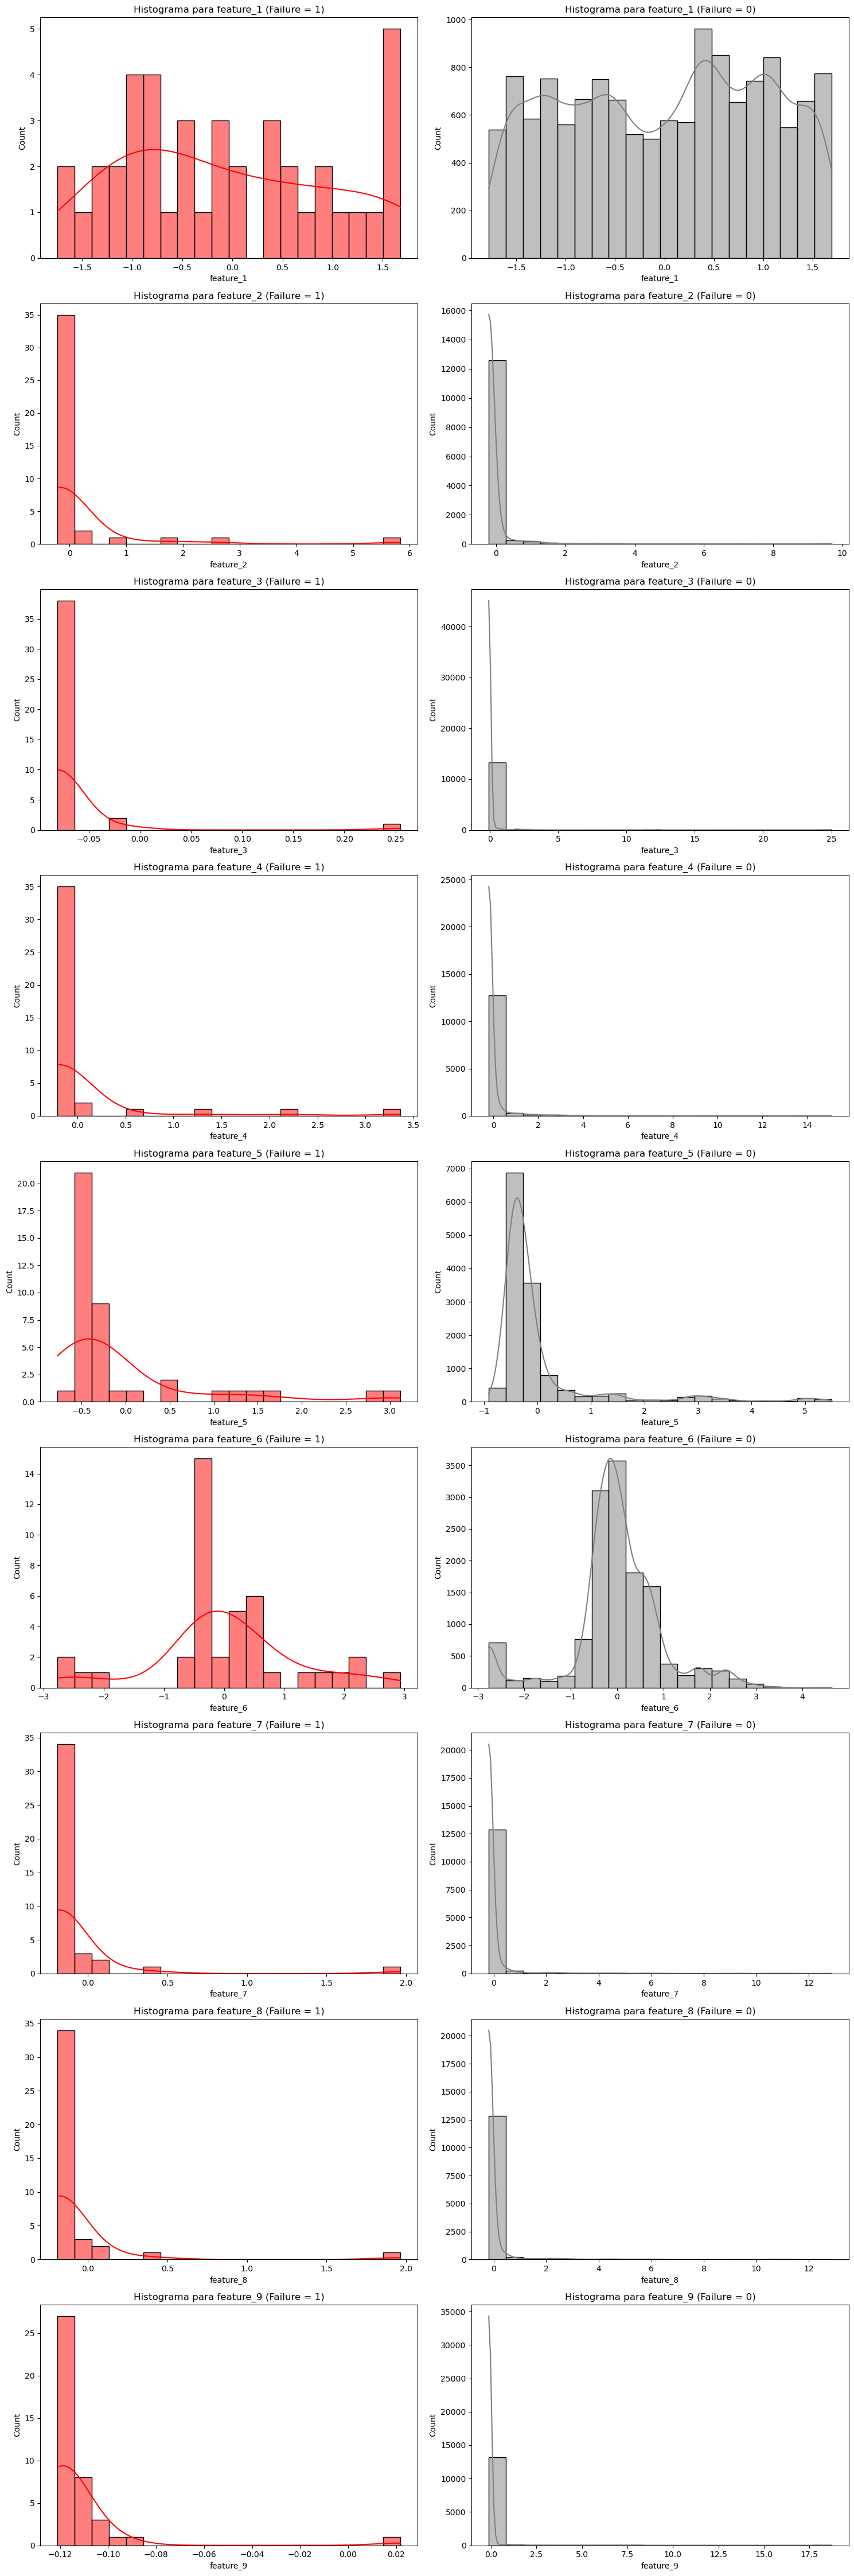

In [14]:
multiple_histograms_by_failure(X_train_scaled,y_train_resampled)

No se puede suponer u observar una diferencia evidente entre la distribución para alguno de los atributos con los dispositivos que presentan falla.

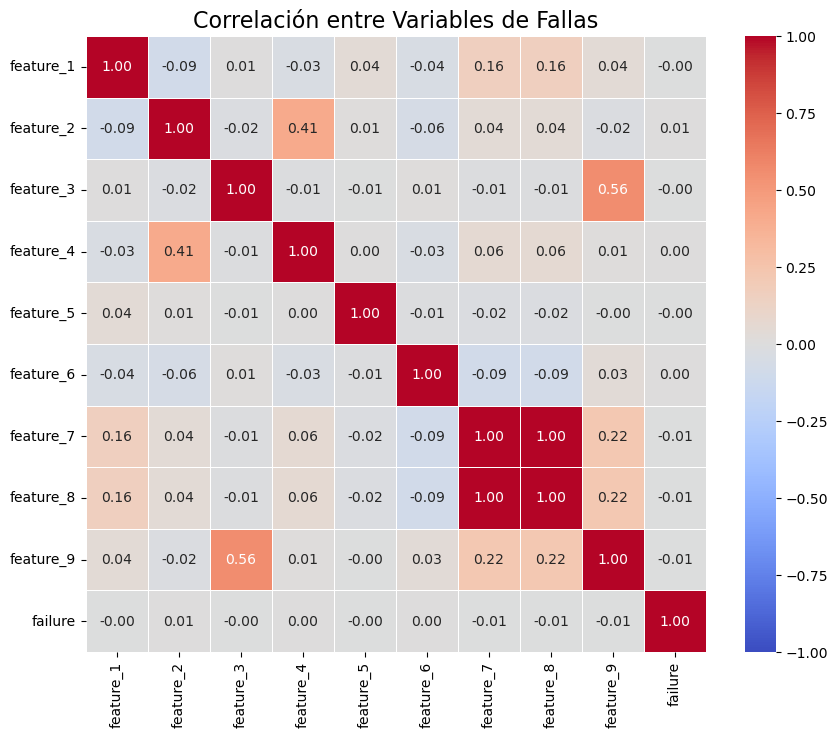

In [15]:
#Correlacion entre variables

# Crear un DataFrame a partir de X_train_scaled y agregar y_train_resampled como una columna
df_scaled_resampled = pd.DataFrame(X_train_scaled, columns=[f'feature_{i+1}' for i in range(X_train_scaled.shape[1])])
df_scaled_resampled['failure'] = y_train_resampled

# Calcular la matriz de correlación
correlation_matrix = df_scaled_resampled.corr()

# Crear el corr plot con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlación entre Variables de Fallas', fontsize=16)
plt.show()

A pesar que las variables numéricas tienen unas distribuciones similares entre sí como vimos en los histogramas, en la matriz de correlación se desmiente cualquier tipo de relación lineal entre ellas, exceptuando los atributos 7 y 8 que al tener una correlación perfecta podría tratarse incluso de una variable repetida. Por este motivo se procede a eliminar alguna de las dos para no agregar ruido y redundancia al modelo.

In [16]:
#Eliminar la característica de los conjuntos de X, tanto 

X_train_scaled = np.delete(X_train_scaled, 6, axis=1)
X_test_scaled = np.delete(X_test_scaled, 6, axis=1)

Ahora que contamos con las variables seleccionadas, estandarizadas y los conjuntos balanceados podemos proceder a la selección de modelo para predecir las fallas

## Modelo predictivo failure

Para predecir **la probabilidad** de falla entre 0 y 1 podría usarse modelos como:

- Regresión logística
- Redes Neuronales
- XGboost
- SVM

Al no ser un modelo de gran complejidad con muchas variables o registros descartaríamos el uso de una red neuronal, dado que implicaría un esfuerzo alto en comparación con el beneficio en términos de rendimiento que podría resultar. 

La regresión logística, puede ser una buena opción considerando su capacidad explicativa, la posibilidad de asignar pesos a las variables en este caso los costos de predecir incorrectamente y también su rendimiento en cuanto a ser un modelo sencillo. Sin embargo las variables que usaremos para predecir de por sí carecen de un significado explicativo y buscando una capacidad de predecir mejor la clase minoritaria con relaciones no necesariamente linealles, no la tendremos en cuenta como primera opción.

#### **Selección del modelo**
Con base a lo anterior, para llevar a cabo el ejercicio implementaremos SVM y XGBoost. Dos modelos que ofrecen buenos resultados en casos similares según otros casos de uso. 

#### **Preprocesamiento**
No es necesario hacer uso de técnicas previas como componentes principales para reducir la dimensionalidad dado que no son tantas variables y modelos como XGBoost y SVM ya se encargan de identificar comportamientos en común.

#### **Métrica de evaluación**
La métrica de evaluación para este caso será el **recall** debido al desbalanceo que existe entre las clases a predecir, ya que es más importante según los costos mencionados, lograr identificar de manera precisa un evento donde el dispositivo falle.
 

### **Construcción del modelo XGBoost**

In [17]:
# Definir el modelo con un random state para que sea consistente

model = xgb.XGBClassifier(random_state=15)

# Definir el espacio de búsqueda
param_grid = {
    'n_estimators': [430, 450, 500],
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [5, 6, 7],
    'gamma': [0, 0.05, 0.25]
}


# Configurar GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring='recall', cv=3, n_jobs=-1, verbose=2)

# Ejecutar la búsqueda en cuadrícula con los datos
grid_search.fit(X_train_scaled, y_train_resampled)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=15, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.05, 0.25],
                         'learning_rate': [0.15, 0.2, 0.25],
                         'max_depth': [5, 6, 7],
                         'n_estimators': [430, 450, 500]},
             scoring='recall', verbose=2)

In [18]:
# Mejores hiperparámetros y modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:", best_params)

Mejores hiperparámetros encontrados: {'gamma': 0, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 450}


In [19]:
# Predecir probabilidades en el conjunto de prueba
probabilities = best_model.predict_proba(X_test_scaled)

# La segunda columna corresponde a la probabilidad de falla
failure_probabilities = probabilities[:, 1]

df_probabilities = pd.DataFrame({'prob_fail_xgboost': failure_probabilities})

# Mostrando las primeras filas del DataFrame para verificar
df_probabilities.describe()


prob_fail_xgboost
count       2.489900e+04
mean        7.919556e-03
std         6.461859e-02
min         2.416597e-11
25%         1.069838e-06
50%         1.339005e-05
75%         1.905589e-04
max         9.999955e-01

### Resultados modelo XGBoost

In [20]:
# Definir los costos
costo_falso_negativo = 1   # Costo de falla no detectada
costo_falso_positivo = 0.5 # Costo de mantenimiento innecesario

# Inicializar el mínimo costo a un valor muy alto
min_costo = float('inf')
mejor_umbral = 0

# Evaluar diferentes umbrales
for umbral in np.linspace(0, 1, 101):
    # Convertir probabilidades a predicciones binarias basadas en el umbral
    predicciones = (failure_probabilities >= umbral).astype(int)

    # Calcular la matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_test, predicciones).ravel()

    # Calcular el costo total para este umbral
    costo_total = fn * costo_falso_negativo + fp * costo_falso_positivo

    # Si este umbral tiene un costo menor, actualizar el mínimo costo y el mejor umbral
    if costo_total < min_costo:
        min_costo = costo_total
        mejor_umbral = umbral
    print(f"Umbral {mejor_umbral} con un costo total de: {min_costo}")

print(f"Mejor umbral: {mejor_umbral} con un costo total de: {min_costo}")


Umbral 0.0 con un costo total de: 12439.0
Umbral 0.01 con un costo total de: 554.5
Umbral 0.02 con un costo total de: 412.0
Umbral 0.03 con un costo total de: 342.0
Umbral 0.04 con un costo total de: 303.0
Umbral 0.05 con un costo total de: 279.5
Umbral 0.06 con un costo total de: 258.5
Umbral 0.07 con un costo total de: 245.0
Umbral 0.08 con un costo total de: 225.5
Umbral 0.09 con un costo total de: 213.0
Umbral 0.1 con un costo total de: 203.0
Umbral 0.11 con un costo total de: 193.0
Umbral 0.12 con un costo total de: 184.0
Umbral 0.13 con un costo total de: 176.0
Umbral 0.14 con un costo total de: 170.0
Umbral 0.15 con un costo total de: 165.5
Umbral 0.16 con un costo total de: 160.5
Umbral 0.17 con un costo total de: 153.0
Umbral 0.18 con un costo total de: 146.0
Umbral 0.19 con un costo total de: 143.0
Umbral 0.2 con un costo total de: 142.0
Umbral 0.21 con un costo total de: 137.5
Umbral 0.22 con un costo total de: 133.5
Umbral 0.23 con un costo total de: 130.0
Umbral 0.24 con u

De aqui obtenemos un resultado de mejor umbral de 1, que significaría no clasificar ningun dispositivo para que presente una falla, e incurrir en el costo de 21 unidades. 

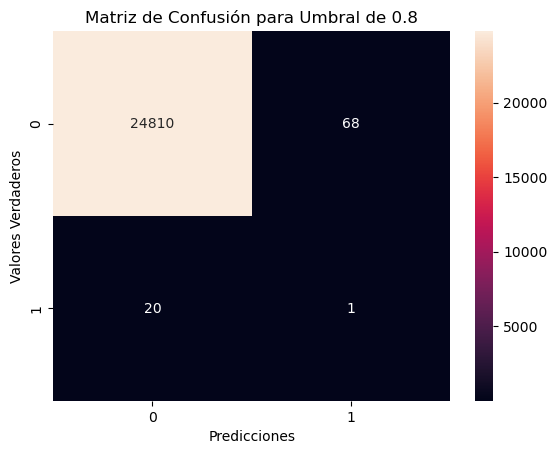

In [21]:
# Umbral específico para la matriz de confusión
umbral_especifico = 0.8

# Convertir probabilidades a predicciones binarias basadas en el umbral específico
predicciones_umbral = (failure_probabilities >= umbral_especifico).astype(int)

# Calcular la matriz de confusión para el umbral específico
matriz_confusion_umbral = confusion_matrix(y_test, predicciones_umbral)

# Visualizar la matriz de confusión
sns.heatmap(matriz_confusion_umbral, annot=True, fmt='g')
plt.title(f'Matriz de Confusión para Umbral de {umbral_especifico}')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

De la matriz de confusión podríamos decir que realmente no está clasificando de manera correcta a los verdaderos positivos y por ende el recall del modelo no es el esperado, esto explica que en las líneas anteriores el modelo prefiriera clasificar todos los dispositivos sin falla y asumir el costo por las mismas. 

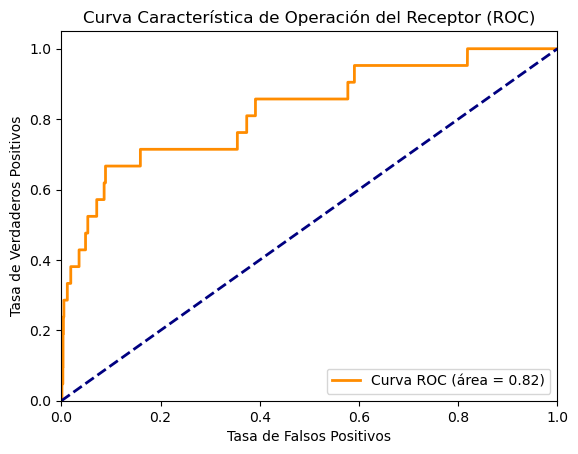

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Suponiendo que 'failure_probabilities' contiene las probabilidades de falla predichas por tu modelo
# y 'y_test' contiene las etiquetas verdaderas

# Calcular la curva ROC y el área bajo la curva
fpr, tpr, thresholds = roc_curve(y_test, failure_probabilities)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()


Sin embargo, a pesar que la función de costos asociados a las fallas y mantenimiento indique que es mejor no predecir las fallas, en la curva ROC podemos ver que el modelo realiza estas predicciones de probabilidad en general de forma apropiada y que como vimos al inicio, la condición de desbalanceo en las clases es la que causa que al final los costos y la variable de falla positiva sea tan compleja de estimar de manera apropiada. Para comparar este modelo frente a otro usaremos SVM. 

### Construcción del modelo SVM

In [23]:
#Definición del modelo con random state de 1
''''
svm_model = SVC(probability=True, random_state=1504)

param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search_svm = GridSearchCV(svm_model, param_grid_svm, scoring='recall', cv=3, n_jobs=-1, verbose=2)

# Ejecutar la búsqueda en cuadrícula
grid_search_svm.fit(X_train_scaled, y_train_resampled)
''''''

SyntaxError: incomplete input (740608138.py, line 15)

In [ ]:
''''
best_params_svm = grid_search_svm.best_params_
best_svm_model = grid_search_svm.best_estimator_
print("Mejores hiperparámetros para SVM:", best_params_svm)
''''''

In [ ]:
''''
# Predecir probabilidades con el mejor modelo SVM
svm_probabilities = best_svm_model.predict_proba(X_test_scaled)

# Extraer las probabilidades de la clase de falla
svm_failure_probabilities = svm_probabilities[:, 1]

# Crear un DataFrame para estas probabilidades
df_svm_probabilities = pd.DataFrame({
    'prob_fail_svm': svm_failure_probabilities
})

df_svm_probabilities
''''

El costo computacional generado para ejecutar el modelo SVM propuesto en estas líneas es mucho más alto en comparación con el XGBoost. Para hacerlo posible podría utilizarse una muestra de los datos para correr el modelo, sin embargo en el conjunto completo ya existe poca cantidad de registros con falla = 1 y un muestreo sobre esto implicaría ser cuidadosos nuevamente con el balanceo y las clases que fueron sobremuestreadas, ya que no representan realmente el verdadero comportamiento natural de la variable.

Debido a lo anterior preferimos realizar un modelo de regresión logística donde asignamos los costos por la clasificación incorrecta de las fallas al modelo y evaluarlo en comparación al XGBoost en términos de capacidad predictiva y función de costos.

### Construcción del modelo Regresión Logística

In [29]:
# Prediciendo directamente las clases 1 y 0 con los pesos 
# Asignar pesos para reflejar los costos de los errores

# Peso para no falla 0.5
# Peso para falla 1
weights = {0: 0.5, 1: 1}

log_reg_model = LogisticRegression(class_weight=weights)

# Entrenar modelo
log_reg_model.fit(X_train_scaled, y_train_resampled)

# Predicciones en el conjunto de prueba
y_pred = log_reg_model.predict(X_test_scaled)

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular y mostrar otras métricas de rendimiento
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     24878
           1       0.01      0.52      0.03        21

    accuracy                           0.97     24899
   macro avg       0.51      0.75      0.51     24899
weighted avg       1.00      0.97      0.98     24899



In [30]:
# Desempaquetar los valores de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()

# Definir los costos para falsos negativos y falsos positivos
costo_falso_negativo = 1   # Costo de falla no detectada
costo_falso_positivo = 0.5  # Costo de mantenimiento innecesario

# Calcular el costo total
costo_total = fn * costo_falso_negativo + fp * costo_falso_positivo

print("Matriz de Confusión:\n", conf_matrix)
print("Costo Total:", costo_total)


Matriz de Confusión:
 [[24116   762]
 [   10    11]]
Costo Total: 391.0


Del reporte vemos como este modelo de regresión logística también sufre al momento de tratar de predecir la clase minoritaria, nuevamente debido al problema de balanceo natural que existe en la base original y se ve reflejado al momento de ver los resultados. Sin embargo el objetivo es predecir la probabilidad de falla y con ella evaluar la función de costos, de la siguiente forma:

In [27]:
# Realizar predicciones de probabilidad en el conjunto de prueba
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]  #predecir probabilidad de la clase 'falla' 


# Definir los costos
costo_falso_negativo = 1   # Costo de falla no detectada
costo_falso_positivo = 0.5 # Costo de mantenimiento innecesario

# Inicializar el mínimo costo a un valor muy alto
min_costo = float('inf')
mejor_umbral = 0

# Evaluar diferentes umbrales
for umbral in np.linspace(0, 1, 101):
    # Convertir probabilidades a predicciones binarias basadas en el umbral
    predicciones = (y_pred_proba >= umbral).astype(int)

    # Calcular la matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_test, predicciones).ravel()

    # Calcular el costo total para este umbral
    costo_total = fn * costo_falso_negativo + fp * costo_falso_positivo

    # Si este umbral tiene un costo menor, actualizar el mínimo costo y el mejor umbral
    if costo_total < min_costo:
        min_costo = costo_total
        mejor_umbral = umbral
    print(f"Umbral {mejor_umbral} con un costo total de: {min_costo}")

print(f"Mejor umbral: {mejor_umbral} con un costo total de: {min_costo}")

Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.0 con un costo total de: 12439.0
Umbral 0.18 con un costo total de: 12438.0
Umbral 0.19 con un costo total de: 12388.0
Umbral 0.2 con un costo total de: 11857.5
Umbral 0.21 con un costo total de: 10656.5
Umbral 0.22 con un costo total de: 9351.0
Umbral 0.23 con un costo total 

El costo total en este caso mejora frente a la predicción realizada directamente sobre las clases, pero nuevamente nos invita a no realizar ninguna clasificación en la clase de falla, siendo mejor opción incurrir en el costo asociado a estas, dado que son una pequeña cantidad.

## Conclusiones y recomendaciones


- Realizar un modelo que tenga en consideración los tipos de dispositivos
- Incluir la variable de dispositivos con un target encoding (?)

Podemos concluir, que el desbalanceo en este conjunto de datos impacta de manera significativa los resultados del modelo, aún utilizando técnicas para balancear y aumentar la clase minoritaria, se agrega quizás un ruido al modelo que hace dificil tener un valor de recall muy alto en diferentes técnicas usadas.

Otra conclusión importante a la que nos llevaron estos modelos es el escenario donde sin estimar estas fallas se obtiene una función de costos mejor que corriendo el riesgo de predecirlas de manera incorrecta, nuevamente debido al desbalanceo que existe en la clase a predecir.

Por último, un hallazgo en común por parte de los dos modelos, es que la diferencia entre los costos de falla y mantenimiento no son tan altos, llevando así a concluir que es mejor incurrir en ellos. Sin embargo, asignando diferentes valores para estos costos permite que ambos modelos mejoren su capacidad de predecir el **recall** y así las identificación de fallas con umbrales distintos a 1.

Se recomienda evaluar el costo de estos fallos, y de ser posible mejorar la calidad en la recolección de la información para contar con clases más balanceadas que permitan aplicar los modelos propuestos para la predicción.